# Finetuning Bert

## Libraries

In [11]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import os 
import torch.nn.functional as F
from utils.dataset_handling import DatasetPreparer
import evaluate
import numpy as np

## Global variables

In [12]:
dataset_path = "Naela00/ToxiFrench"

## Load dataset and model

In [13]:
model_id = "AgentPublic/camembert-base-toxic-fr-user-prompts"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, 
    num_labels=2, 
    ignore_mismatched_sizes=True 
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at AgentPublic/camembert-base-toxic-fr-user-prompts and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.config.id2label = {0: 'Non Toxic', 1: 'Toxic'}
model.config.label2id = {'Non Toxic': 0, 'Toxic': 1}

In [15]:
class BertDatasetPreparer(DatasetPreparer):
    def formatting_func(self, row):
        label = 1 if "oui" in str(row[self.label_field]).lower() else 0
        
        tokenized = self.tokenizer(
            row[self.text_field],
            padding="max_length",
            truncation=True,
            max_length=128 
        )
        
        tokenized["labels"] = label
        
        return tokenized

In [16]:
preparer = BertDatasetPreparer(
    tokenizer, 
    text_field="content", 
    label_field="literal_conclusion_annotator", 
    oversampling=True
)

train_ds = preparer.prepare(dataset_path, split_name="train")
eval_ds = preparer.prepare(dataset_path, split_name="test")

In [17]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [19]:
training_args = TrainingArguments(
    output_dir="/Data/AxelDlv/camembert-toxic-finetuned-v2",
    eval_strategy="steps",  
    eval_steps=100,   
    save_strategy="steps",           
    save_steps=100,
    save_total_limit=3,
    learning_rate=2e-6,             
    per_device_train_batch_size=128,
    num_train_epochs=3,              
    weight_decay=0.01,
    load_best_model_at_end=True,     
    metric_for_best_model="f1",
    report_to="tensorboard",
    logging_steps=50,
    logging_dir='/Data/AxelDlv/BertTrainingLogs-v2',
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

Step,Training Loss,Validation Loss,F1
100,0.600800,0.585968,0.748547
200,0.521400,0.532577,0.778007
300,0.480000,0.512490,0.772464
400,0.456500,0.500851,0.775421
500,0.447100,0.490461,0.781911
600,0.416900,0.488494,0.784024
700,0.413200,0.488644,0.789045
800,0.399200,0.489248,0.790455
900,0.384700,0.487604,0.794948
1000,0.385500,0.487797,0.791324


TrainOutput(global_step=2352, training_loss=0.3939595712082727, metrics={'train_runtime': 1809.7033, 'train_samples_per_second': 166.191, 'train_steps_per_second': 1.3, 'total_flos': 1.978305714146304e+16, 'train_loss': 0.3939595712082727, 'epoch': 3.0})

In [22]:
trainer.save_model("/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel")
tokenizer.save_pretrained("/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel")

('/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel/tokenizer_config.json',
 '/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel/special_tokens_map.json',
 '/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel/sentencepiece.bpe.model',
 '/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel/added_tokens.json',
 '/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel/tokenizer.json')

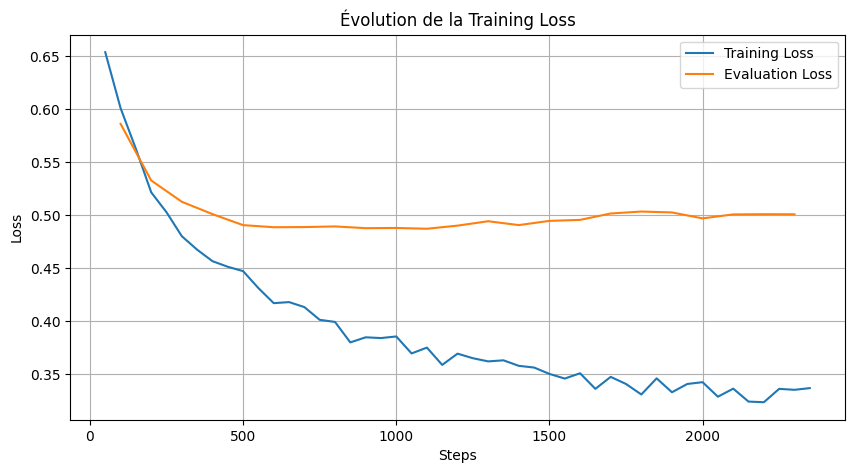

In [24]:
import matplotlib.pyplot as plt

# Extraire les logs
history = trainer.state.log_history

# Filtrer pour obtenir la training loss
train_loss = [x['loss'] for x in history if 'loss' in x]
steps = [x['step'] for x in history if 'loss' in x]

test_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
test_steps = [x['step'] for x in history if 'eval_loss' in x]

# Affichage
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(test_steps, test_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Évolution de la Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Example use of the model 

from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    "/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel"
)
tokenizer = AutoTokenizer.from_pretrained(
    "/Data/AxelDlv/camembert-toxic-finetuned-v2/FinalModel"
)

dataset_preparer = DatasetPreparer(
    tokenizer, 
    text_field="content", 
    label_field="literal_conclusion_annotator"
)

ds_test = dataset_preparer.prepare(dataset_path, split_name="test")

Formatting dataset: 100%|██████████| 1388/1388 [00:00<00:00, 12420.81 examples/s]


In [ ]:
def predict_toxicity(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    toxic_prob = probs[0][1].item()
    non_toxic_prob = probs[0][0].item()
    if toxic_prob > non_toxic_prob:
        return "Toxic", toxic_prob
    else:
        return "Non Toxic", non_toxic_prob
    
for i in range(10):
    text = ds_test[i]['prompt'].replace("Message:\n","").replace("\n\nAnalyse:\n","")
    label, confidence = predict_toxicity(text)
    print(f"Texte: {text}\nLabel: {label}, Confidence: {confidence:.4f}\n")

Texte: 2 morts, le terroriste n'a plus été vu depuis l'attaque.
Label: Non Toxic, Confidence: 0.9923

Texte: Pour quoi on devrait les accueillir ? Il sont très bien où ils sont c’est à dire chez eux
Label: Non Toxic, Confidence: 0.9919

Texte: Osef je me casse dans deux mois
:hap:
Label: Non Toxic, Confidence: 0.9926

Texte: Elle courait vite la pute , le peuple des ténèbres c'est dingue,
Label: Toxic, Confidence: 0.9860

Texte: Personne pour une reconstitution du vocaroo delete ?
:rire:
Label: Non Toxic, Confidence: 0.9925

Texte: vous misez sur quoi ? perso : homicide involontaire (enfant battu) puis maquillage du meurtre
Label: Toxic, Confidence: 0.9801

Texte: MAIS POURQUOI ILS FONT UNE SUITE A CETTE DAUBE???
Label: Non Toxic, Confidence: 0.9830

Texte: Elle est laide comme un pou
:rire:
Label: Toxic, Confidence: 0.9833

Texte: wtf comment t'as fait pour utiliser un sticker khey
:ouch:
Label: Non Toxic, Confidence: 0.9926

Texte: Bouffe lui le chibre a KD nan ?
Label: Toxic, Confid